# Module 1 Final Project Submission
* Team Name: MERRY! (Mia Iseman & Sherry Yang) 
* Blog post URL: https://tiny.cc/kbpe5y
* Presentation URL: https://tiny.cc/c7oe5y

## Goal: 
## Predict the sale price of properties in King County, WA within a 20% median absolute error

## Process
1. Business Understanding
2. Data Understanding 
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

## Business Understanding 

### Project Context 
HomeAway, an Airbnb and VRBO competitor was recently acquired by Expedia, whose corporate offices are located in Bellvue, WA. They've given us a set of data from 2014-2015. They would like us to make a model that predicts the property prices, give or take 20%. If we're successful, they will consider hiring us for future consulting projects that deal with more recent data.

### Business Needs
* HomeAway is considering opening an office in King County. They want to know how much employees will be paying for their homes if they were to relocate. They are also interested in purchasing homes in the area for special event rentals and executive suites. 
* HomeAway's business model is based on people from all walks of life renting out their homes to strangers. If they are able to tell their customer base a predicted price or profit for using HomeAway, then they can increase business. They can also modify internal budgets, sales strategies, and operations.
* HomeAway is interested in any tangential knowledge we gain from features within the data set.

## Data Understanding 

In [2]:
# import various helpful libraries 
import pandas as pd   
import numpy as np 
import matplotlib as plt
import math as math
import seaborn as sns

#read the file as a dataframe
kc_df = pd.read_csv('kc_house_data.csv')

FileNotFoundError: [Errno 2] File b'kc_house_data.csv' does not exist: b'kc_house_data.csv'

In [ ]:
kc_df.head().T

#### HomeAway provided initial descriptions for the data, and after meeting with them, we clarified a few things:  
* **id** - unique identifier for a house
* **date** - sale date
* **price** - (TARGET) - sales price of the property
* **bedrooms** -  number of bedrooms per property
* **bathrooms** -  number of of bathrooms per property
* **sqft_living** -  total living area in square feet
* **sqft_lot** -  total area of the lot in square feet
* **floors** -  floors (levels) in the property
* **waterfront** - property with a view to a waterfront. Null values imply it is unknown.
* **view** - number of "interesting" views from the property." Null values imply it is unknown.
* **condition** - overall condition rating given to the property 
* **grade** - based on the King County glossary, this is the "classification by construction quality which refers to the types of materials used and the quality of workmanship."
* **sqft_above** - total living area apart from basement in square feet
* **sqft_basement** - total area of the basement. 0 values imply there is no basement.
* **yr_built** - year the property was built
* **yr_renovated** - year the property was renovated. Null values imply it was never renovated.
* **zipcode** - zipcode of property
* **lat** - latitude coordinate of property
* **long** - longitude coordinate of property
* **sqft_living15** - total living area for the nearest 15 neighboring properties in square feet
* **sqft_lot15** - total area of the lots of the nearest 15 neighboring properties

## Data Preparation

In [ ]:
kc_df.info()

In [ ]:
#change the date column objects to be datetime entries
kc_df.date = pd.to_datetime(kc_df.date, format='%m/%d/%Y')

In [ ]:
kc_df['sqft_basement'].unique()

In [ ]:
#convert basement values to numbers with any errors becoming null values 
kc_df['sqft_basement'] = pd.to_numeric(kc_df['sqft_basement'], errors='coerce')

In [ ]:
#investigate null value locations
kc_df.isna().sum()

These columns are expected to have null values.

In [ ]:
kc_df.info()

## Data Preparation 
The season of sale may influence the price. 

In [ ]:
import datetime
def find_date(dates):
    """Convert the date to a day number where Jan 1 = 0 and Dec 31 = 365"""
    output = []
    for date in dates: 
        day_of_year = (date - datetime.datetime(date.year, 1, 1)).days + 1
        output.append(day_of_year)
    return output

In [ ]:
#change the dates to numbers since the year doesn't matter in our business context 
date_series = pd.Series(find_date(kc_df['date']))

In [ ]:
#drop the original date column from our dataframe
kc_df = kc_df.drop(["date"], axis=1)

In [ ]:
#bucket the year into seasons
season_days = dict(
    winter=set(range(1,80)).union(set(range(352,367))),
    spring=set(range(80,171)),
    summer=set(range(171,264)),
    autumn=set(range(264,352)),
                   )

In [ ]:
def find_season(days_from_jan1):
    """Return the season as a string"""
    for season, days in season_days.items():
        if days_from_jan1 in days:
            return season

In [ ]:
#change the numbers to seasons
date_series = date_series.apply(find_season)

In [ ]:
#add the season column to the dataframe 
kc_df = pd.concat([kc_df, date_series], axis =1)
kc_df.rename(columns={0:'season'}, 
                 inplace=True) 

In [ ]:
#replace the season names with numbers that rank the popular seasons as higher 
kc_df.loc[kc_df["season"]=='spring','season'] = 4
kc_df.loc[kc_df["season"]=='summer','season'] = 2
kc_df.loc[kc_df["season"]=='autumn','season'] = 3
kc_df.loc[kc_df["season"]=='winter','season'] = 1
kc_df['season'].head()

Change the waterfront type to a categorical variable. Use dummy variables to append two dummy variable columns to the end of the dataframe. 

In [ ]:
water_series = pd.Series(kc_df.waterfront)
kc_df['waterfront'] = water_series.astype('category')

In [ ]:
kc_df = pd.get_dummies(kc_df)
#rename waterfront 1.0 to waterfront
kc_df = kc_df.rename(columns={"waterfront_1.0": "waterfront"})

#drop the null and zero values column
kc_df = kc_df.drop(['waterfront_0.0'], axis=1) 

kc_df.head().T

#### Investigate location and proximity to other locations as a feature that influences price. 
Combine latitude and longitude into one feature.

In [ ]:
coords = tuple(zip(kc_df.loc[:,'lat'], kc_df.loc[:,'long']))
coordinates = pd.Series(coords)
kc_df['coordinates'] = coordinates

If the property is near an "expensive area," its location may affect the price of the home. See how zipcode and price of the home are related as well as any outliers we may be dealing with.

In [ ]:
kc_df.plot(kind="scatter", x="zipcode", y="price", alpha=0.8, figsize=(15,10))
plt.tight_layout

If the property is near an "expensive area," its location may affect the price of the home. To find "expensive areas," look at median home value (as opposed to mean, thus lessening outliers' effects and gearing our eventual model more towards the HomeAway use case) grouped by zipcodes:

In [ ]:
#isolate the price and zipcodes into a dataframe
price_zips_df = kc_df[['price','zipcode']]

In [ ]:
#view the median home price by zipcode 
median_zip_prices_df = price_zips_df.groupby(['zipcode']).median()

In [ ]:
#sort those values and see the most expensive median home values 
median_zip_prices_df.sort_values(by=['price']).tail(20)

The priciest median home zipcodes are near these areas:

_Note: We checked this using Google Maps by hand due to time, but would like to have used other tools to do this._

In [ ]:
#Mia: put these into a dictionary 
downtown_seattle = (47.612476, -122.331772)
downtown_bellevue = (47.617382, -122.188503)
pine_lake = (47.587821, -122.034408)
magnolia = (47.649777, -122.399839)
woodinville = (47.757905, -122.049466)
kirkland = (47.676908, -122.192552)
tiger_mtn = (47.498987, -121.959350)
issaquah = (47.558402, -122.007307)
redmond = (47.659389, -122.056730)

Create columns for the distance from these areas. We use haversine, which assumes the earth is a perfect sphere. This is fine for our purposes since the distances are not very large.

In [ ]:
from haversine import haversine 

dt_seattle_mi = []
for row in kc_df.coordinates:
    a = haversine(row, downtown_seattle, unit='mi')
    dt_seattle_mi.append(a) 
kc_df['seattle_dist'] = dt_seattle_mi
#Mia: rewrite this function so outputs a dictionary (and input is the above dictionary)   

dt_bellevue_mi = []
for row in kc_df.coordinates:
    a = haversine(row, downtown_bellevue, unit='mi')
    dt_bellevue_mi.append(a)
kc_df['bellevue_dist'] = dt_bellevue_mi

pine_lake_mi = []
for row in kc_df.coordinates:
    a = haversine(row, pine_lake, unit='mi')
    pine_lake_mi.append(a)
kc_df['pine_lake_dist'] = pine_lake_mi

magnolia_mi = []
for row in kc_df.coordinates:
    a = haversine(row, magnolia, unit='mi')
    magnolia_mi.append(a)
kc_df['magnolia_dist'] = magnolia_mi

woodinville_mi = []
for row in kc_df.coordinates:
    a = haversine(row, woodinville, unit='mi')
    woodinville_mi.append(a)
kc_df['woodinville_dist'] = woodinville_mi

kirkland_mi = []
for row in kc_df.coordinates:
    a = haversine(row, kirkland, unit='mi')
    kirkland_mi.append(a)
kc_df['kirkland_dist'] = kirkland_mi

tiger_mtn_mi = []
for row in kc_df.coordinates:
    a = haversine(row, tiger_mtn, unit='mi')
    tiger_mtn_mi.append(a)
kc_df['tiger_mtn_dist'] = tiger_mtn_mi

issaquah_mi = []
for row in kc_df.coordinates:
    a = haversine(row, issaquah, unit='mi')
    issaquah_mi.append(a)
kc_df['issaquah_dist'] = issaquah_mi

redmond_mi = []
for row in kc_df.coordinates:
    a = haversine(row, redmond, unit='mi')
    redmond_mi.append(a)
kc_df['redmond_dist'] = redmond_mi

Create columns that group these areas together based on commerce vs. residential/recreational appeal. Hypothesis: Proximity to large commerce centers has a more widespread effect than proximity to residential/recreational centers.

In [ ]:
#create a column of distances (mi) to the nearest the commerce center
comm_distances = kc_df[['seattle_dist', 'bellevue_dist', 'redmond_dist']].min(axis=1)
kc_df['comm_dist'] = comm_distances

In [ ]:
#create a column of distances (mi) to the nearest center of any type 
center_distances= kc_df[['seattle_dist', 'bellevue_dist', 'pine_lake_dist',
       'magnolia_dist', 'woodinville_dist', 'kirkland_dist', 'tiger_mtn_dist',
       'issaquah_dist', 'redmond_dist']].min(axis=1)
kc_df['center_dist'] = center_distances
kc_df.head().T

#### Investigate quality of property as a feature that influences price
Find the area per room in square feet. Hypothesis: Total area of the home in combination with the number of bathroom and bedrooms will be a better price predictor than the individual features separately. 


In [ ]:
kc_df['sqft_per_room'] = kc_df['sqft_living']/(kc_df['bedrooms']+kc_df['bathrooms'])

Create a new feature that combines grade, view, waterfront, and condition. Hypothesis: A single "appeal" feature will be a better price predictor than individual features. 

In [ ]:
#import necessary library to use a standardscaler
from sklearn.preprocessing import StandardScaler

#scale the features
ss = StandardScaler()
kc_looks_std = kc_df[['grade', 'view', 'waterfront', 'condition']]
kc_looks_std = pd.DataFrame(ss.fit_transform(kc_looks_std),
                          columns = ['grade_std', 'view_std', 'waterfront_std', 
                                      'condition_std'])
    
kc_looks_std.head()

In [ ]:
#the warning is just letting us know that our numbers were converted to integers, which is fine

In [ ]:
#create a formula to relate these values
#Mia: add detail WHY we did this! 
kc_df['appeal_std']= kc_looks_std.apply(lambda x: 4*x['grade_std'] + 
                                          x['view_std'] + 2*x['waterfront_std'] + 
                                          x['condition_std'],axis= 1)
kc_df.info()

In [ ]:
#drop the rows where appeal is null
kc_df = kc_df.loc[~kc_df['appeal_std'].isna(), :]

In [ ]:
#drop redundant or columns we aren't going to use 
kc_df = kc_df.drop(['id', 'lat', 'long', 'sqft_living', 'bedrooms', 'bathrooms', 'coordinates',
                    'sqft_basement', 'zipcode', 'yr_renovated'], axis=1) 

In [1]:
#view histograms of the features to visualize their distributions
kc_df.hist(figsize=(15,12))
plt.tight_layout

NameError: name 'kc_df' is not defined

In [36]:
#log price to normalize it 
price_log = np.log(kc_df['price'])
price_log = pd.Series(price_log)
kc_df['price_log'] = price_log
kc_df = kc_df.drop('price', axis = 1)

In [37]:
#Find the statistical description of the features.
kc_df.describe().head().T

,count,mean,std,min,25%
sqft_lot,21534.0,15090.596359,41380.209856,520.000000,5040.000000
floors,21534.0,1.494126,0.539806,1.000000,1.000000
view,21534.0,0.233863,0.765686,0.000000,0.000000
condition,21534.0,3.409724,0.650654,1.000000,3.000000
grade,21534.0,7.657425,1.172643,3.000000,7.000000
sqft_above,21534.0,1788.557537,827.745641,370.000000,1190.000000
yr_built,21534.0,1971.002275,29.376044,1900.000000,1951.000000
sqft_living15,21534.0,1986.299944,685.121001,399.000000,1490.000000
sqft_lot15,21534.0,12751.079502,27255.483308,651.000000,5100.000000
season,21534.0,2.670846,1.094371,1.000000,2.000000


<module 'matplotlib.tight_layout' from '/Users/tjjj/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py'>

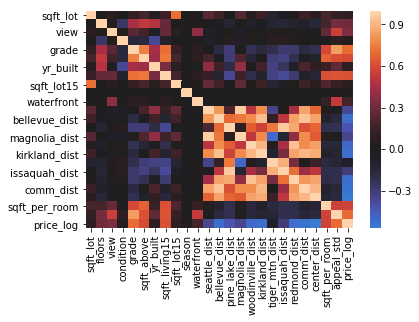

In [38]:
#make a heatmap to see how these features correlate
sns.heatmap(kc_df.corr(), center=0);
plt.tight_layout

Some distances are close together, so they have a higher correlation. No features are multicollinear.

Use sklearn to select which of these features are the best predictors of price.

In [39]:
#import SelectKBest for feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [40]:
#set y to the target and X to all other features except target 
y = np.ravel(kc_df[["price_log"]])
X = kc_df.drop(["price_log"], axis=1)

In [41]:
#select the best price predictor features
X_new = SelectKBest(score_func=f_classif,k=7).fit_transform(X, y)
#return the first three values of the best 6 features
print(X_new[:3].T)

[[   7.            7.            6.        ]
 [1180.         2170.          770.        ]
 [1340.         1690.         2720.        ]
 [   7.81782286    7.52180779    8.58044055]
 [   7.81782286    6.19315603    4.61472207]
 [ 295.          489.52380952  256.66666667]
 [  -3.34362305   -3.34362305   -6.75318131]]


In [42]:
#match the best predictors shown with the column names 
print(X.head(3).T)

                            0            1             2
sqft_lot          5650.000000  7242.000000  10000.000000
floors               1.000000     2.000000      1.000000
view                 0.000000     0.000000      0.000000
condition            3.000000     3.000000      3.000000
grade                7.000000     7.000000      6.000000
sqft_above        1180.000000  2170.000000    770.000000
yr_built          1955.000000  1951.000000   1933.000000
sqft_living15     1340.000000  1690.000000   2720.000000
sqft_lot15        5650.000000  7639.000000   8062.000000
season               3.000000     3.000000      1.000000
waterfront           0.000000     0.000000      0.000000
seattle_dist         7.817823     7.521808      9.808899
bellevue_dist        8.001373     9.387358      8.580441
pine_lake_dist      11.652547    16.127943     13.889794
magnolia_dist       11.661730     6.193156      9.862826
woodinville_dist    19.593891    12.780978      8.637925
kirkland_dist       11.836595  

Appeal includes grade, so disregarding grade, the "best" 6 feature predictors are sqft_above, sqft_living15, comm_dist, center_dist, sqft_per_room, and appeal_std. Use these when modeling the data. 

## Modeling

Create a new dataframe that contains our model predictors and target alone.

In [43]:
model_df = kc_df[['sqft_above', 'sqft_living15', 'comm_dist', 'center_dist', 
                  'sqft_per_room', 'appeal_std', 'price_log']] 

Split the data into a training set and a test set.

In [44]:
from sklearn.model_selection import train_test_split
y = model_df[["price_log"]]
X = model_df.drop(["price_log"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [45]:
#import linear regression class 
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

#create the model using our training set 
linreg.fit(X_train, y_train)

#run the model  
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [46]:
#peep the model's r-squared
linreg.score(X,y)

0.7727960711942768

In [55]:
linreg.coef_

array([[ 0.00010771,  0.00010179, -0.0169556 , -0.02713158,  0.00059031,
         0.0376671 ]])

### Our final model formula is: 

Predicted log price = 0.00010771 * (sqft_above) + 0.00010179 * (sqft_living15) - 0.0169556 * (comm_dist) - 0.02713158 * (center_dist) + 0.00059031 * (sqft_per_room) + 0.0376671 * (appeal_std)

Some interesesting findings: 
* The area of one home and the area of the neighbors' homes influence the price about the same. However, the "area per room" is more influential than either of those features. 
* The distance from any "center" is doubly influential compared to the distance from the commerce centers when predicting log price, and seven times more influential when predicting price.  

In [56]:
#cross-validate results 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_median_absolute_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_median_absolute_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=100, scoring="neg_median_absolute_error"))

## Evaluation

In [57]:
#view the median aboslute percent error during cross-validation
print(abs(cv_5_results), abs(cv_10_results), abs(cv_20_results))

0.15293754672757948 0.15277930406938944 0.15264641826863626


In [58]:
def exp_absolute_error(y_actual, y_hat):
    """Backtransform price_log"""
    return abs(np.exp(y_actual.values)-np.exp(y_hat))/(np.exp(y_actual.values))

In [59]:
#Take the median absolute percent error of our test data.
np.median(exp_absolute_error(y_test, y_hat_test))

0.14986990238093106

Our median aboslute percent error of our test data set is consistently less than 16%.

The success metric, median absolute percent error < 20%, has been met. 

## Deployment
HomeAway will hire us for consulting where they will deploy similarly made models, with lower errors. 